In [1]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

In [2]:
ORIGINAL_DATA_DIR = os.path.join("..", "handout", "data")
BERT_FEATURE_DIR = os.path.join("..", "bert_output_data")

In [3]:
train_dataframe = pd.read_csv(os.path.join(ORIGINAL_DATA_DIR, "lang_id_train.csv"))

In [4]:
bert_vectors_train = []
with open(os.path.join(BERT_FEATURE_DIR, "train.jsonlines"), "rt") as infile:
    for line in infile:
        bert_data = json.loads(line)
        for t in bert_data["features"]:
            # Only extract the [CLS] vector used for classification
            if t["token"] == "[CLS]":
                # We only use the representation at the final layer of the network
                bert_vectors_train.append(t["layers"][0]["values"])
                break

In [5]:
len(bert_vectors_train)

6000

In [6]:
x_train = np.array(bert_vectors_train)
y_train = train_dataframe["native_language"].values

In [7]:
eval_dataframe = pd.read_csv(os.path.join(ORIGINAL_DATA_DIR, "lang_id_eval.csv"))

In [8]:
bert_vectors_eval = []
with open(os.path.join(BERT_FEATURE_DIR, "eval.jsonlines"), "rt") as infile:
    for line in infile:
        bert_data = json.loads(line)
        for t in bert_data["features"]:
            # Only extract the [CLS] vector used for classification
            if t["token"] == "[CLS]":
                # We only use the representation at the final layer of the network
                bert_vectors_eval.append(t["layers"][0]["values"])
                break

In [9]:
len(bert_vectors_eval)

2000

In [10]:
x_eval = np.array(bert_vectors_eval)
y_eval = eval_dataframe["native_language"].values

In [11]:
test_dataframe = pd.read_csv(os.path.join(ORIGINAL_DATA_DIR, "lang_id_test.csv"))

In [12]:
bert_vectors_test = []
with open(os.path.join(BERT_FEATURE_DIR, "test.jsonlines"), "rt") as infile:
    for line in infile:
        bert_data = json.loads(line)
        for t in bert_data["features"]:
            # Only extract the [CLS] vector used for classification
            if t["token"] == "[CLS]":
                # We only use the representation at the final layer of the network
                bert_vectors_test.append(t["layers"][0]["values"])
                break

In [13]:
len(bert_vectors_test)

2000

In [14]:
x_test = np.array(bert_vectors_test)
y_test = test_dataframe["native_language"].values

In [15]:
languages = sorted(test_dataframe['native_language'].unique())
def get_evaluation_metrics(model, model_name):
    print("Accuracies")
    print("Training Accuracy:", model.score(x_train, y_train))
    print("Evaluation Accuracy:", model.score(x_eval, y_eval))
    print("Testing Accuracy:", model.score(x_test, y_test))
    test_dataframe[model_name] = model.predict(x_test)
    
    
    
    #Confusion Matrix
    print("Confusion Matrix")
    con_mat = confusion_matrix(test_dataframe['native_language'], test_dataframe[model_name])
    plt.figure(figsize = (15,10.5))
    ax = sns.heatmap(con_mat, annot=True, cmap="YlGnBu", xticklabels=languages, yticklabels=languages)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
    test_lang = test_dataframe.groupby(model_name).count()['native_language']
    misclassifications_test = []
    
    # Extract Misclassification from the confusion matrix
    for item in range(len(languages)):
        misclassification = ((200 - con_mat[item][item] + (test_lang[item] - con_mat[item][item])) / 2000) * 100
        misclassifications_test.append(misclassification)
    
    precision, recall, fscore, support = precision_recall_fscore_support(test_dataframe['native_language'], test_dataframe[model_name])
    
    # Enter the evaluation results in a dataframe for pretty print
    results = pd.DataFrame(columns=['Language', 'Misclassification', 'Precision', 'Recall', 'F1 Score'])
    for item in range(len(languages)):
        results = results.append(pd.DataFrame([[languages[item], misclassifications_test[item], precision[item], recall[item], fscore[item]]], 
                                              columns=['Language', 'Misclassification', 'Precision', 'Recall', 'F1 Score']))
        
    print("Evaluation Metrics for each Language")
    print(results.to_string())
    print()
    
    # Get the within-class misclassifications
    results_class = pd.DataFrame(columns=['Language', 'Predicted', 'Misclassification'])
    for x in languages:
        for y in languages:
            if(x != y):
                results_class = results_class.append(pd.DataFrame([[x,y, con_mat[languages.index(x)][languages.index(y)]]], 
                                                                  columns=['Language', 'Predicted', 'Misclassification']))
    
    print("Within class Misclassifications")
    print(results_class.to_string())
    print()
    
    print("Short Summary on Misclassifications")
    print("Total data:", test_dataframe.shape[0])
    print("Total predicted incorrect:", results_class['Misclassification'].sum())
    print("Total predicted correct:", (test_dataframe.shape[0] - results_class['Misclassification'].sum()))

In [16]:
logisticregression_model = LogisticRegression(penalty="l2", C=1.0, solver='liblinear', 
                              multi_class='auto', random_state=20200414, max_iter=5000)
logisticregression_model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20200414, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

Accuracies
Training Accuracy: 0.7345
Evaluation Accuracy: 0.4855
Testing Accuracy: 0.466
Confusion Matrix


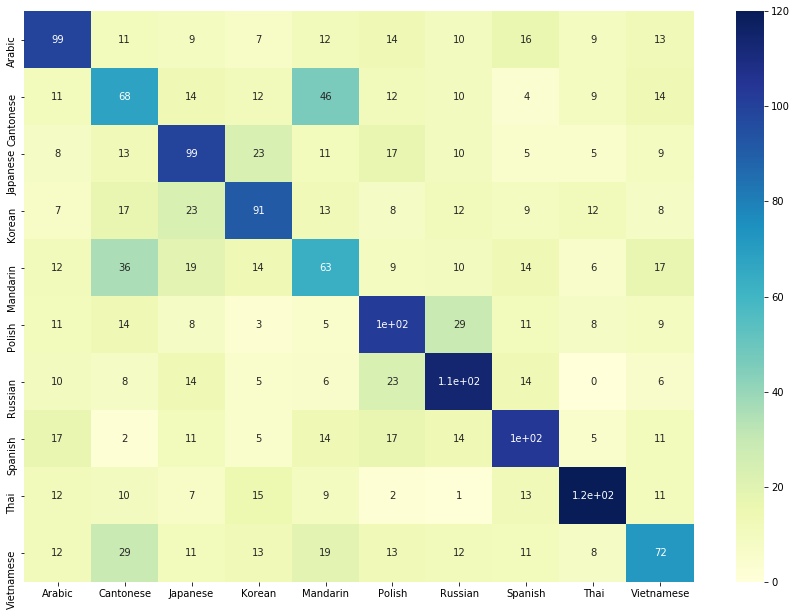

Evaluation Metrics for each Language
     Language  Misclassification  Precision  Recall  F1 Score
0      Arabic              10.05   0.497487   0.495  0.496241
0   Cantonese              13.60   0.326923   0.340  0.333333
0    Japanese              10.85   0.460465   0.495  0.477108
0      Korean              10.30   0.484043   0.455  0.469072
0    Mandarin              13.60   0.318182   0.315  0.316583
0      Polish              10.65   0.470046   0.510  0.489209
0     Russian               9.70   0.513514   0.570  0.540284
0     Spanish               9.65   0.517413   0.520  0.518703
0        Thai               7.10   0.659341   0.600  0.628272
0  Vietnamese              11.30   0.423529   0.360  0.389189

Within class Misclassifications
     Language   Predicted Misclassification
0      Arabic   Cantonese                11
0      Arabic    Japanese                 9
0      Arabic      Korean                 7
0      Arabic    Mandarin                12
0      Arabic      Polish   

In [17]:
get_evaluation_metrics(logisticregression_model, 'logistic_regression')

In [18]:
# Get probability of every class
eval_lang = eval_dataframe.groupby('native_language').count()
prob_class = eval_lang.min() / eval_lang.sum()
print(prob_class)

text    0.1
dtype: float64


In [19]:
def build_NeuralNetwork(activation, nLayer, nHiddenNeuron):
    model = MLPClassifier(hidden_layer_sizes=(nHiddenNeuron,)*nLayer
                            ,activation=activation, verbose=False
                            ,solver='lbfgs', learning_rate_init=0.1
                            ,max_iter=5000, random_state=20200414)
    
    # Fit the data
    fit = model.fit(x_train, y_train)
    y_pred_prob = fit.predict_proba(x_eval)
    
    # Using threshold as 0.1 as every class has a probability of 0.1
    y_pred = np.where(y_pred_prob[:,1] >= 0.1,1,0)
    nIter = model.n_iter_
    Loss = model.loss_
    Misclassification = 1 - fit.score(x_eval, y_eval)
    return(nIter, Loss, Misclassification)

In [20]:
# Create empty dataframe for storing the results
result_NeuralNetwork = pd.DataFrame(columns = ['Activation', 'nLayer', 'nHiddenNeuron', 'nIter', 'Loss', 'Misclassification'])

# Using different activation functions
# Logistic and Relu get executed pretty fast as the model converges in short steps as we hit a local minima
for activation in ['logistic', 'relu', 'tanh', 'identity']:
    for i in np.arange(50,80, 10):
        for j in np.arange(80,110,10):
            nIter, Loss, Misclassification = build_NeuralNetwork(activation, nLayer = i, nHiddenNeuron = j)
            result_NN = result_NN.append(pd.DataFrame([[activation, i, j, nIter, Loss, Misclassification]],
                                   columns = ['Activation', 'nLayer', 'nHiddenNeuron', 'nIter', 'Loss', 'Misclassification']))
            print(activation, i, j, nIter, Loss, Misclassification)

logistic 50 80 6 2.3025964988736844 0.9
logistic 50 90 6 2.302597896786693 0.9
logistic 50 100 6 2.302599311505143 0.9
logistic 60 80 6 2.30259872480037 0.9
logistic 60 90 6 2.302600411445833 0.9
logistic 60 100 5 2.3026021002791626 0.9
logistic 70 80 6 2.3026009599926747 0.9
logistic 70 90 9 2.302602907455814 0.9
logistic 70 100 6 2.3026048611796 0.9
relu 50 80 7 2.3026193794592436 0.9
relu 50 90 8 2.302623517023708 0.9
relu 50 100 7 2.302627740938479 0.9
relu 60 80 8 2.302626020772239 0.9
relu 60 90 7 2.3026310753403028 0.9
relu 60 100 7 2.3026360904598544 0.9
relu 70 80 9 2.3026327387628496 0.9
relu 70 90 7 2.302638557450433 0.9
relu 70 100 7 2.3026444099497536 0.9
tanh 50 80 5002 1.5847513581193258 0.638
tanh 50 90 5001 0.8935290634813771 0.611
tanh 50 100 5001 0.024614485012145297 0.6174999999999999
tanh 60 80 5001 1.7632561148456611 0.7395
tanh 60 90 5001 1.896288351638856 0.763
tanh 60 100 5001 0.6381876628017723 0.6655
tanh 70 80 5001 0.13990036179057364 0.6365000000000001
tanh

In [21]:
file_name = 'neural_network_final.csv'
result_NerualNetwork.to_csv(file_name, sep=',')

In [22]:
result_NeuralNetwork = pd.read_csv('neural_network_final.csv', sep=',', index_col=0)
result_NeuralNetwork

,Activation,nLayer,nHiddenNeuron,nIter,Loss,Misclassification
0,logistic,50,80,6,2.302596,0.9000
0,logistic,50,90,6,2.302598,0.9000
0,logistic,50,100,6,2.302599,0.9000
0,logistic,60,80,6,2.302599,0.9000
0,logistic,60,90,6,2.302600,0.9000
0,logistic,60,100,5,2.302602,0.9000
0,logistic,70,80,6,2.302601,0.9000
0,logistic,70,90,9,2.302603,0.9000
0,logistic,70,100,6,2.302605,0.9000
0,relu,50,80,7,2.302619,0.9000


In [23]:
lowest_misclassification_df = result_NeuralNetwork[result_NeuralNetwork.Misclassification == result_NeuralNetwork.Misclassification.min()]
lowest_misclassification_df

,Activation,nLayer,nHiddenNeuron,nIter,Loss,Misclassification
0,identity,50,100,5001,1.240108,0.512


In [25]:
fittest_nn_model = MLPClassifier(hidden_layer_sizes=(100,)*50,activation='identity', verbose=False,solver='lbfgs',
                                 learning_rate_init=0.1,max_iter=5000, random_state=20200414)
fittest_nn = fittest_nn_model.fit(x_train, y_train)

Accuracies
Training Accuracy: 0.5656666666666667
Evaluation Accuracy: 0.488
Testing Accuracy: 0.4625
Confusion Matrix


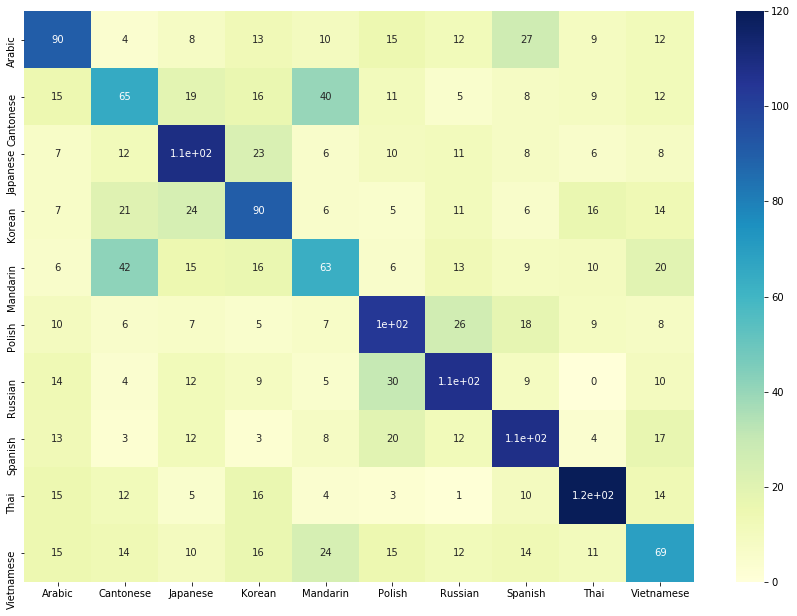

Evaluation Metrics for each Language
     Language  Misclassification  Precision  Recall  F1 Score
0      Arabic              10.60   0.468750   0.450  0.459184
0   Cantonese              12.65   0.355191   0.325  0.339426
0    Japanese              10.15   0.493213   0.545  0.517815
0      Korean              11.35   0.434783   0.450  0.442260
0    Mandarin              12.35   0.364162   0.315  0.337802
0      Polish              10.55   0.474886   0.520  0.496420
0     Russian               9.80   0.509524   0.535  0.521951
0     Spanish              10.05   0.497696   0.540  0.517986
0        Thai               7.70   0.618557   0.600  0.609137
0  Vietnamese              12.30   0.375000   0.345  0.359375

Within class Misclassifications
     Language   Predicted Misclassification
0      Arabic   Cantonese                 4
0      Arabic    Japanese                 8
0      Arabic      Korean                13
0      Arabic    Mandarin                10
0      Arabic      Polish   

In [26]:
get_evaluation_metrics(fittest_nn, 'NN_Misclassification')

In [27]:
lowest_loss_df = result_NeuralNetwork[result_NeuralNetwork.Loss == result_NeuralNetwork.Loss.min()]
lowest_loss_df

,Activation,nLayer,nHiddenNeuron,nIter,Loss,Misclassification
0,tanh,50,100,5001,0.024614,0.6175


In [28]:
fittest_nn_l_model = MLPClassifier(hidden_layer_sizes=(100,)*50,activation='tanh', verbose=False,solver='lbfgs',
                                   learning_rate_init=0.1,max_iter=5000, random_state=20200414)
fittest_nn_l = fittest_nn_l_model.fit(x_train, y_train)

Accuracies
Training Accuracy: 0.9958333333333333
Evaluation Accuracy: 0.3825
Testing Accuracy: 0.3775
Confusion Matrix


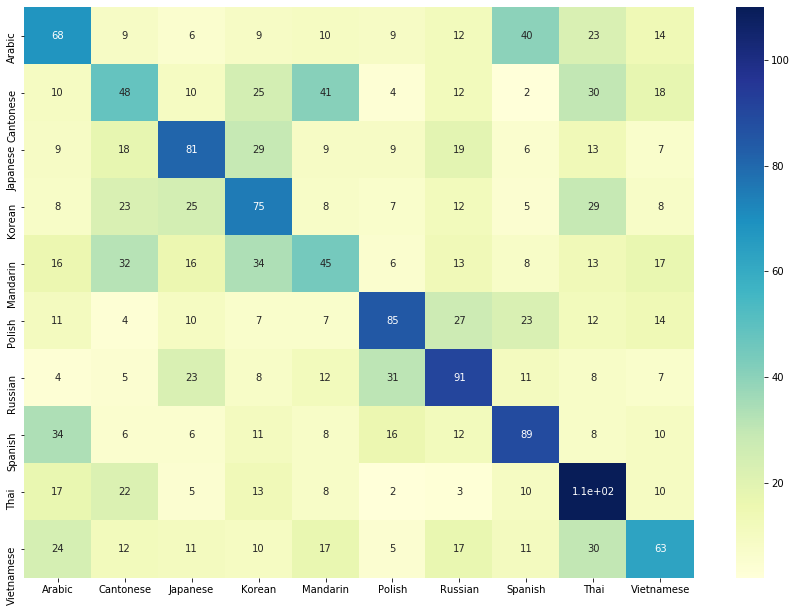

Evaluation Metrics for each Language
     Language  Misclassification  Precision  Recall  F1 Score
0      Arabic              13.25   0.338308   0.340  0.339152
0   Cantonese              14.15   0.268156   0.240  0.253298
0    Japanese              11.55   0.419689   0.405  0.412214
0      Korean              13.55   0.339367   0.375  0.356295
0    Mandarin              13.75   0.272727   0.225  0.246575
0      Polish              10.20   0.488506   0.425  0.454545
0     Russian              11.80   0.417431   0.455  0.435407
0     Spanish              11.35   0.434146   0.445  0.439506
0        Thai              12.80   0.398551   0.550  0.462185
0  Vietnamese              12.10   0.375000   0.315  0.342391

Within class Misclassifications
     Language   Predicted Misclassification
0      Arabic   Cantonese                 9
0      Arabic    Japanese                 6
0      Arabic      Korean                 9
0      Arabic    Mandarin                10
0      Arabic      Polish   

In [29]:
get_evaluation_metrics(fittest_nn_l, 'NN_Loss')

(6000, 768)
(6000, 2)
          X1         X2         y
0  22.006414 -10.209376  Japanese
1  37.829624  35.069004  Japanese
2  16.350712  51.899437  Japanese


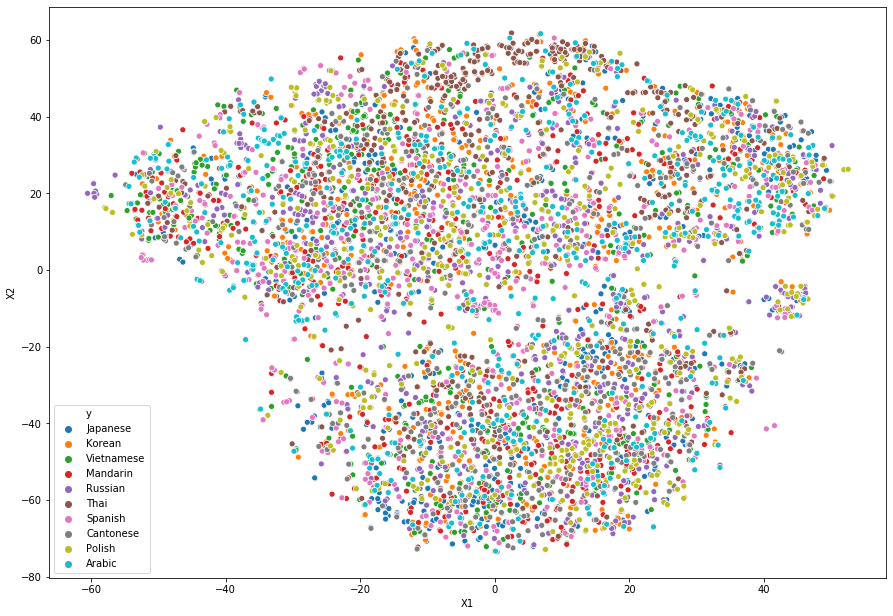

In [30]:
print(x_train.shape)
X_train_min = TSNE(n_components=2).fit_transform(x_train)
print(X_train_min.shape)
train_df_min = pd.DataFrame({'X1': X_train_min[:,0], 
                             'X2': X_train_min[:,1], 
                             'y': y_train})
print(train_df_min.head(3))
plt.figure(figsize = (15,10.5))
sns.scatterplot(x="X1", y="X2", hue="y", data=train_df_min)
plt.show()

(2000, 768)
(2000, 2)
          X1         X2         y
0  11.341320  14.688099  Japanese
1  -2.509803 -38.563488  Japanese
2  29.713428  32.711193  Japanese


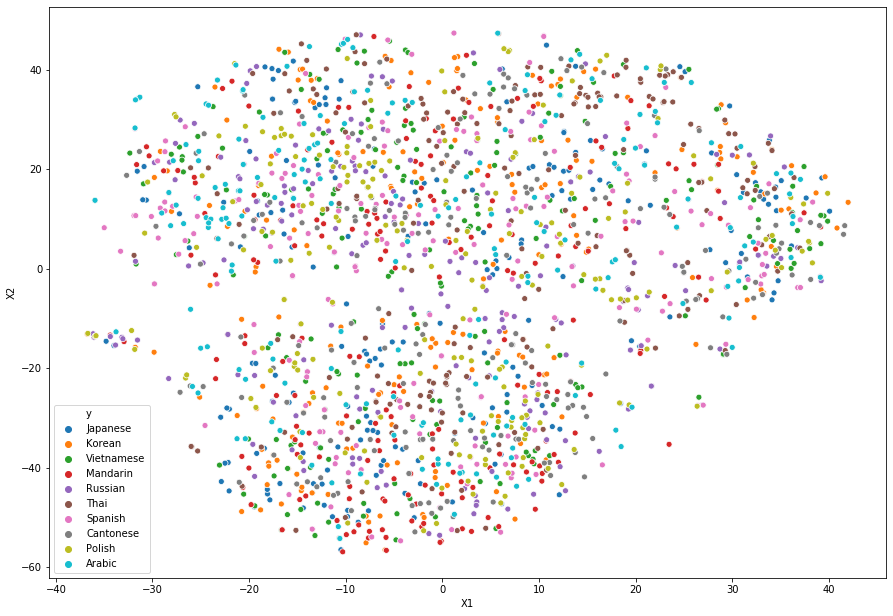

In [31]:
print(x_eval.shape)
X_eval_min = TSNE(n_components=2).fit_transform(x_eval)
print(X_eval_min.shape)
eval_df_min = pd.DataFrame({'X1': X_eval_min[:,0], 
                             'X2': X_eval_min[:,1], 
                             'y': y_eval})
print(eval_df_min.head(3))
plt.figure(figsize = (15,10.5))
sns.scatterplot(x="X1", y="X2", hue="y", data=eval_df_min)
plt.show()

(2000, 768)
(2000, 2)
          X1         X2         y
0  25.788891  37.435444  Japanese
1  28.145004  -4.291864  Japanese
2  17.706825  -4.777357  Japanese


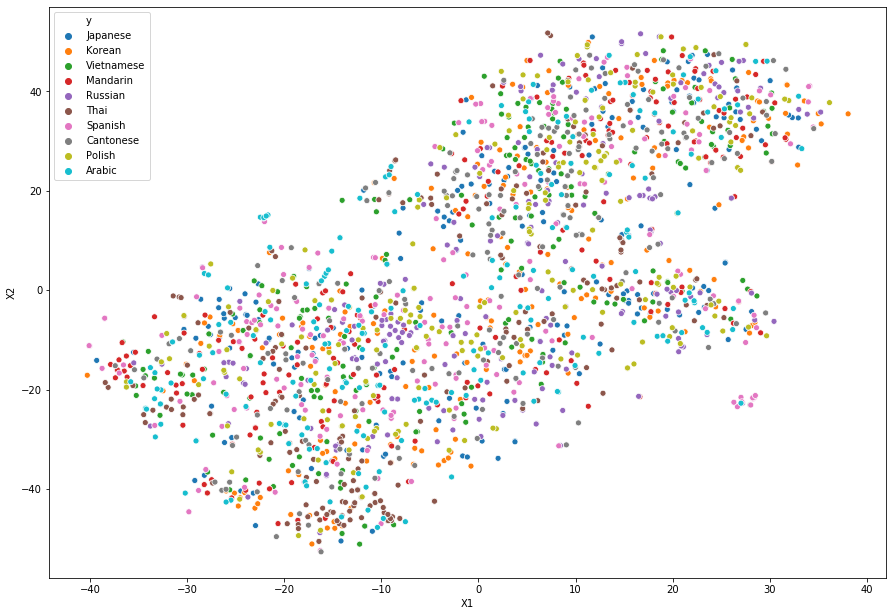

In [32]:
print(x_test.shape)
X_test_min = TSNE(n_components=2).fit_transform(x_test)
print(X_test_min.shape)
test_df_min = pd.DataFrame({'X1': X_test_min[:,0], 
                             'X2': X_test_min[:,1], 
                             'y': y_test})
print(test_df_min.head(3))
plt.figure(figsize = (15,10.5))
sns.scatterplot(x="X1", y="X2", hue="y", data=test_df_min)
plt.show()

In [33]:
logisticregression_model_min = LogisticRegression(penalty="l2", C=1.0, solver='liblinear', 
                              multi_class='auto', random_state=20200414, max_iter=5000)
logisticregression_model_min.fit(X_train_min, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20200414, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

In [34]:
logisticregression_model_min.score(X_train_min, y_train)

0.139